In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import utilities as u

from scipy.io import loadmat
from scipy.interpolate import griddata
from matplotlib import path
from matplotlib.patches import Rectangle
from pathlib import Path

%matplotlib widget

In [8]:
# Load bathymetry data
fn = "Data/Bathymetry/bathymetry.mat"
data = loadmat(fn)['DATA']
coords = data[:,:2]
bathy = data[:,-1]

# Load Coastline data
fn = "Data/Bathymetry/coastline.mat"
coastline = loadmat(fn)["coastline"]

# Plot inner or outer grid?
inner = True

# Save figure?
save = False

In [3]:
# Define region
if inner:
    bl = (-1.63, 43.45)
    tr = (-1.518, 43.54)
else:
    bl = (-2.3, 43.28)
    tr = (-1.42, 43.8)

# Define resolution of grid
res = 1000

coords_box, bathy_box = u.get_data_in_box(coords, bathy, tr, bl)

In [4]:
# Create rectangular grid from box points
x = np.linspace(bl[0], tr[0], res)
y = np.linspace(bl[1], tr[1], res)

X,Y = np.meshgrid(x, y)

# Interpolate data on this grid
bathy_grid = griddata(coords_box, bathy_box, (X, Y), method='linear')

In [5]:
# Turn the meshgrids into corresponding 1D-arrays
coords_box_1D = np.vstack([X.ravel(), Y.ravel()]).T
bathy_box_1D = bathy_grid.ravel()

# Treat Coastline as polygon to check which points fall outside of the polygon
p = path.Path(coastline)
out_idx = p.contains_points(coords_box_1D)

# Set points outside of coastline to NaN
bathy_box_1D[out_idx] = np.nan

# Reshape to original size
bathy_final = bathy_box_1D.reshape((res, res))

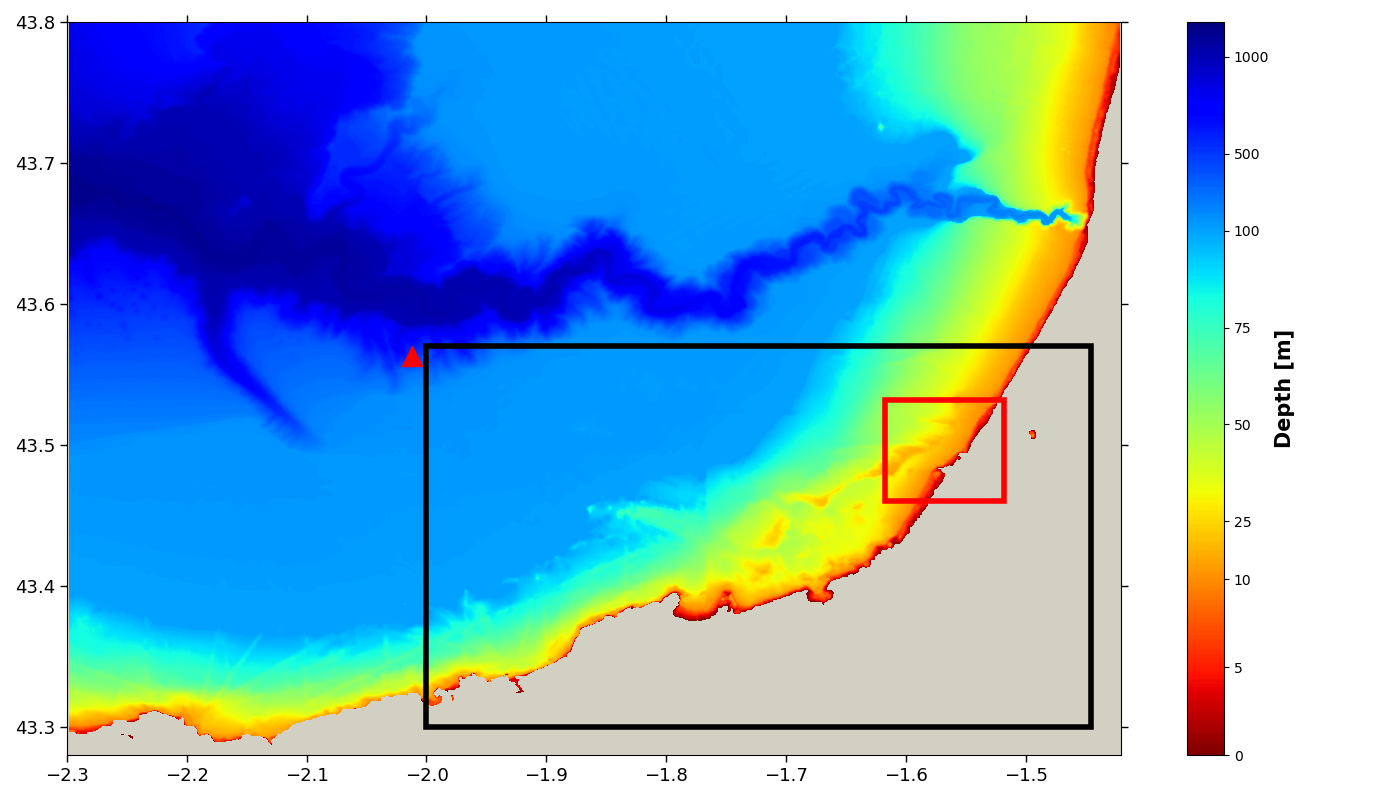

In [6]:
if not inner:
    # Set up a non-linear colormap for outer grid
    class nlcmap(colors.LinearSegmentedColormap):
        """A nonlinear colormap"""

        name = 'nlcmap'

        def __init__(self, cmap, levels):
            self.cmap = cmap
            # @MRR: Need to add N for backend
            self.N = cmap.N
            self.monochrome = self.cmap.monochrome
            self.levels = np.asarray(levels, dtype='float64')
            self._x = self.levels / self.levels.max()
            self._y = np.linspace(0.0, 1.0, len(self.levels))

        #@MRR Need to add **kw for 'bytes'
        def __call__(self, xi, alpha=1.0, **kw):
            """docstring for fname"""
            # @MRR: Appears broken? 
            # It appears something's wrong with the
            # dimensionality of a calculation intermediate
            #yi = stineman_interp(xi, self._x, self._y)
            yi = np.interp(xi, self._x, self._y)
            return self.cmap(yi, alpha)

    levels = np.concatenate((
        [0, 2000],
        np.linspace(0.1,10, 100, endpoint=False),
        np.linspace(10,100, 200, endpoint=False),
        np.linspace(100,1000, 100, endpoint=False),
        np.linspace(1000,2000, 20, endpoint=False)
        ))

    levels.sort()

    cmap_nonlin = nlcmap(plt.cm.jet_r, levels)
    
    # Plot the Bathymetry
    xlim = (-2.3, -1.42)
    ylim = (43.28, 43.8)
    
    # Plotting constants for ticks and labels
    TICKLABELSIZE = 13
    LENGTH = 5.0
    WIDTH= 1.0
    CLABELSIZE = 15
    
    # Choose the colorlabel ticks
    cticks = [0,5,10,25,50,75,100,500,1000]
    extent = (bl[0], tr[0], bl[1], tr[1])
    
    # Draw the rectangles and buoy location
    inner_rect = Rectangle((-1.617, 43.46), 0.0989, 0.072, linewidth=4,
                           edgecolor='r', facecolor='none')
    outer_rect = Rectangle((-2, 43.3), 0.5546, 0.27, linewidth=4,
                           edgecolor='k', facecolor='none')
    buoy_location = (-2.012, 43.563)

    fig, ax = plt.subplots(1, figsize=(14,8))
    # Plot a background color
    plt.gca().patch.set_color("#d2d0c2")

    CS = ax.contourf(bathy_final, levels=levels, cmap=cmap_nonlin, extent=extent)
    # Add the two rectangles and the triangle
    ax.plot(*buoy_location, "r^", markersize=15)
    ax.add_patch(inner_rect)
    ax.add_patch(outer_rect)
    cb = plt.colorbar(CS, ticks=cticks)
    cb.set_label(label='Depth [m]', size=CLABELSIZE, weight='bold')
    
    
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.tick_params(axis='both', left=True, top=True, right=True, bottom=True, 
                   labelleft=True, labelbottom=True, labelsize=TICKLABELSIZE,
                   length=LENGTH, width=WIDTH)


    plt.tight_layout()
    
    fdir = Path("Plots")
    fname = "Bathymetry_Outer.png"

    if save:
        if not fdir.exists():
            fdir.mkdir()
        plt.savefig(fdir /fname)

# Plot inner grid bathymetry

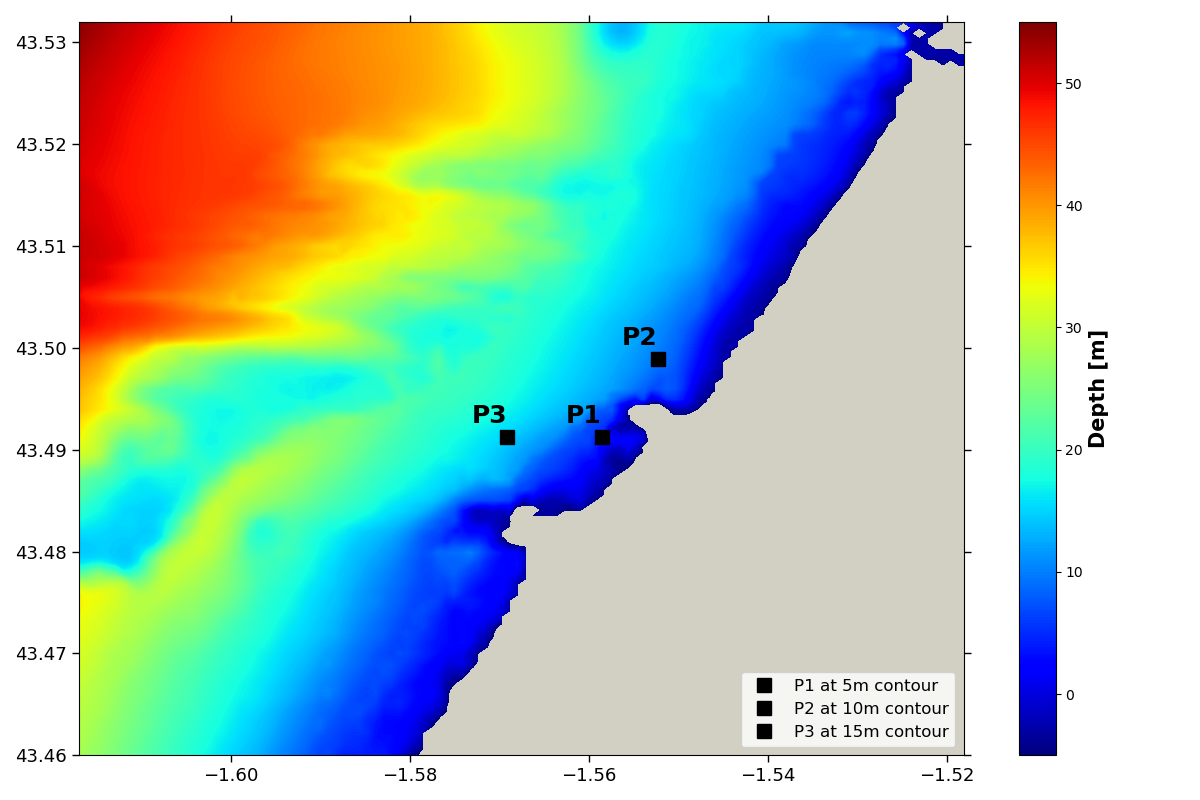

In [11]:
if inner:
    # Define exact limits of inner grid
    bl = (-1.617, 43.46)
    tr = (-1.5181, 43.532)

    xlim = (bl[0], tr[0])
    ylim = (bl[1], tr[1])

    extent = (bl[0], tr[0], bl[1], tr[1])

    # Get the coordinates of the extraction points
    xi = [69, 69, 86]
    yi = [94, 77, 104]

    # 160, since the grid is 160x160
    x = np.linspace(bl[0],tr[0],160)
    y = np.linspace(bl[1],tr[1],160)

    # Min & Max level for the colorbar, define cb-ticks
    vmin = -5
    vmax = 55
    levels = np.linspace(vmin, vmax, 500+1)
    cticks = [0,10,20,30,40,50]

    # Plotting constants for ticks and labels
    LENGTH = 5.0
    WIDTH= 1.0
    TICKLABELSIZE = 13
    CLABELSIZE = 15
    LEGENDFONTSIZE = 12
    TEXTSIZE = 18

    point1 = (x[94], y[69])
    point2 = (x[104], y[86])
    point3 = (x[77], y[69])

    fig, ax = plt.subplots(1, figsize=(12,8))
    # Plot a background color
    plt.gca().patch.set_color("#d2d0c2")

    CS = ax.contourf(X, Y, bathy_final, cmap="jet", levels=levels, vmin=vmin,
                     vmax=vmax)

    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)

    # Plot the colorbar
    cb = plt.colorbar(CS, ticks=cticks)
    cb.set_label(label='Depth [m]', size=CLABELSIZE, weight='bold')

    # Plot the extraction points
    ax.plot(*point1, "sk", label="P1 at 5m contour", markersize=10)
    ax.plot(*point2, "sk", label="P2 at 10m contour", markersize=10)
    ax.plot(*point3, "sk", label="P3 at 15m contour", markersize=10)

    # Add text
    ax.annotate("P1", point1, textcoords="offset points", xytext=(0,10),
                ha="right", size=TEXTSIZE, weight="bold")
    ax.annotate("P2", point2, textcoords="offset points", xytext=(0,10),
                ha="right", size=TEXTSIZE, weight="bold")
    ax.annotate("P3", point3, textcoords="offset points", xytext=(0,10),
                ha="right", size=TEXTSIZE, weight="bold")

    ax.tick_params(axis='both', left=True, top=True, right=True, bottom=True,
                   labelleft=True, labelbottom=True, labelsize=TICKLABELSIZE,
                   length=LENGTH, width=WIDTH)

    ax.legend(loc="lower right", fontsize=LEGENDFONTSIZE)

    plt.tight_layout()

    fdir = Path("Plots")
    fname = "Bathymetry_Inner.png"

    if save:
        if not fdir.exists():
            fdir.mkdir()
        plt.savefig(fdir /fname)